# steps

1. import water body 
1. get bounds
1. format bounds to string
1. use requests to download geojson for area
1. calculate overlap 
1. add data to shapes


In [35]:
# import helper functions 

# add helper function location
import sys 
sys.path.append('../../functions')

from helpers import *

In [137]:
import overpass
import shapely
import fiona
import glob

from shapely.ops import cascaded_union, unary_union
from shapely.geometry import shape, Point

In [138]:
# parameters 
results_files_location = '../../data/nir_green_blue/vectors/'

persil_data_store_location = '../../data/nir_green_blue/persil_overlap/'

geoserver_url = 'https://geosvc.atrbpn.go.id/geoserver/petabpn/'

In [139]:
# create download directory if it does not exist
make_dir(results_files_location)
make_dir(persil_data_store_location)    

Directory  ../../data/nir_green_blue/vectors/  already exists...
Directory  ../../data/nir_green_blue/persil_overlap/  already exists...


In [140]:
len(result_file_list)

446

3.8489336597645527e-07
1.3454175809067335e-07
1.0786437944737948e-08
1.508253528505787e-08


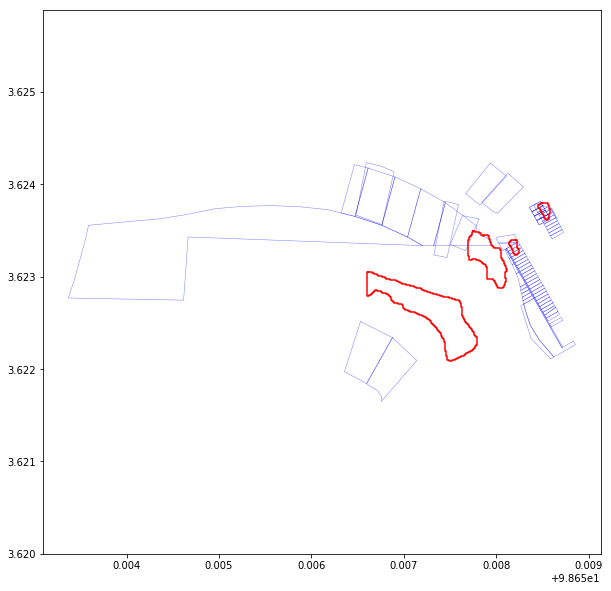

7.057532178618807e-07
1.5088886083198005e-08
7.876184508555736e-08
1.076019500470649e-06
2.884652576301928e-07
1.0572921595721772e-08
8.869268642442435e-08
2.2453546652273814e-07
1.3804725565001327e-08


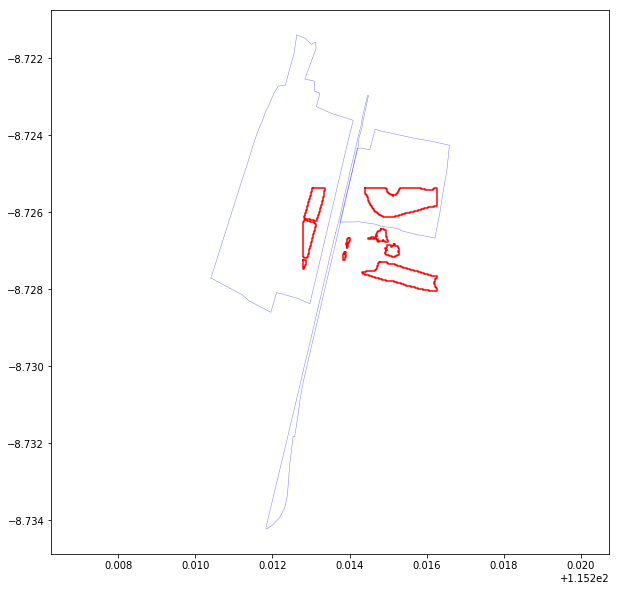

1.9866636861657707e-08
5.156438365335077e-08
2.5735904229157434e-08
2.8832174203408578e-06
5.965545570217815e-08
9.86851579443367e-09
5.417500415418069e-08


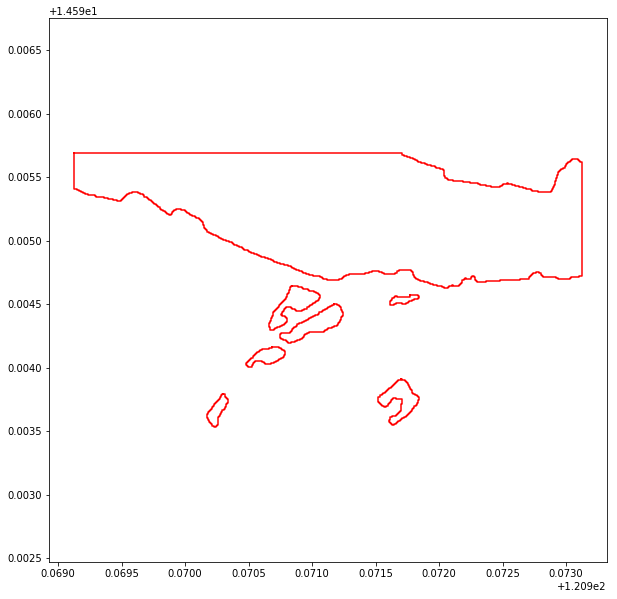

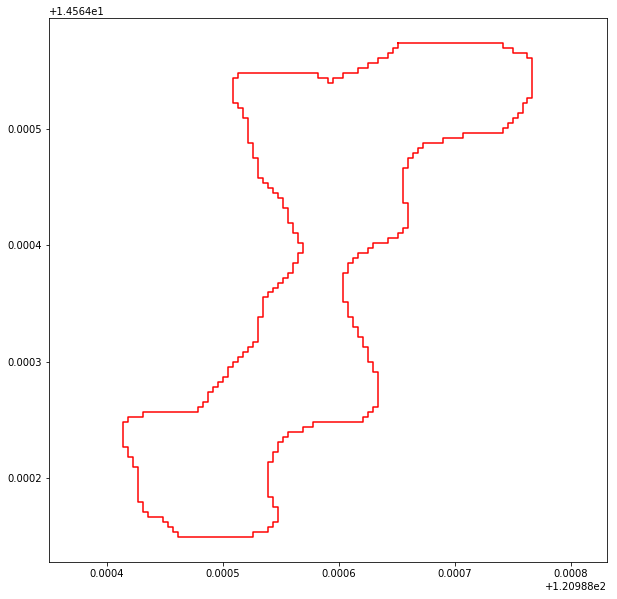

KeyboardInterrupt: 

In [146]:
result_file_list = glob.glob(results_files_location + '*.geojson')


for result_file_path in result_file_list:
    # convert esri shapefiles to shapely objects
    # check valid geometries
    list, result_valid_shape_list, crs_check = check_valid_geometries(result_file_path)

    if not crs_check:
        print('crs not epsg:4623, skipping...')


    # convert list to shapely MultiPolgyons (in wgs84)
    result_wgs_shp = unary_union([shape(pol['geometry']) for pol in result_valid_shape_list])

    result_wgs_shp

    basename = os.path.basename(result_file_path).split('.')[0]

    xmin, ymin, xmax, ymax = result_wgs_shp.bounds 

    max_features = 100000


    url = geoserver_url + 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=petabpn:PersilBerdasarkanJenisHak&maxFeatures={}&outputFormat=application%2Fjson&BBOX={},{},{},{}'.format(
            max_features, xmin, ymin, xmax, ymax)

    local = persil_data_store_location + basename + '.geojson'

    download_file(url, local)


    valid_geom, data, crs_check = check_valid_geometries(local)

    polygon_list_wgs_shp = [shape(pol['geometry']) for pol in valid_geom]

    typehak = []
    for feature in data:
        typehak.append(feature['properties']['TIPEHAK'])

    import geopandas as gpd

    series = gpd.GeoSeries(polygon_list_wgs_shp)

    gdf = gpd.GeoDataFrame(geometry = series)

    len(gdf)

    import matplotlib.pyplot as plt

    fig = plt.figure(figsize = (10,10))


    for percil in gdf.geometry:
        try:
            x,y = [poly.boundary.xy for poly in percil][0]
        except: 
            x,y = [poly.exterior.xy for poly in percil][0]
        plt.plot(x,y, color = 'b', linewidth=0.5, alpha = 0.5)

    if isinstance(result_wgs_shp, shapely.geometry.multipolygon.MultiPolygon):
        for water in result_wgs_shp:
            
            print(water.area)
            
            try:
                x,y = water.boundary.xy
            except:
                x,y = water.exterior.xy

            plt.plot(x,y, color = 'r')
    else: 
        x,y = result_wgs_shp.exterior.xy

        plt.plot(x,y, color = 'r')


    plt.axis('equal')


    plt.show()

In [147]:
import folium



import pandas as pd

try:
    x,y = result_wgs_shp[0].centroid.xy
except:
    x,y = result_wgs_shp.centroid.xy

m = folium.Map(location=[y[0], x[0]], zoom_start=16, max_zoom = 30)

for poly in polygon_list_wgs_shp[0:500]:
    folium.Choropleth(
        geo_data=poly,
        legend_name='persil data'
    ).add_to(m)
    

for poly in [result_wgs_shp]:
    folium.Choropleth(
        geo_data=poly, 
        name='detected water',
    ).add_to(m)


folium.LayerControl().add_to(m)

m

In [148]:
dict((i, typehak.count(i)) for i in typehak)

{}

In [149]:
import numpy as np
import matplotlib.pyplot as plt

In [150]:
typehak_count = [typehak.count(i) for i in np.unique(typehak)]

In [151]:
plt.figure(figsize = (2*len(np.unique(typehak)), 5))
plt.bar(np.unique(typehak), typehak_count)
plt.xlabel('type of registration')
plt.ylabel('number of occurences')

Text(0, 0.5, 'number of occurences')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 0x360 with 1 Axes>